# Creating Single-Burst Interferograms

## 1. The Why

Burst-based InSAR has several major advantages that make it incredibly useful:

1. Bursts are geostationary, so you don't have to worry about migrating SLC frames
2. Bursts are much smaller than SLCs, so you don't have to process a ton of unnessecary data if you're interested in a volcano size feature
3. Because of advantages 1 and 2, HyP3 can offer larger quantities of useful data to users

To get a sense for the migrating frame issue, take a look at these side-by-side SBAS searches over Mt. Edgecumbe. The left search was done using [SLCs in Vertex](https://search.asf.alaska.edu/#/?zoom=8.266&center=-134.416,56.456&polygon=POLYGON((-135.762%2057.0503,-135.7468%2057.0503,-135.7468%2057.0562,-135.762%2057.0562,-135.762%2057.0503))&flightDirs=Descending&resultsLoaded=true&granule=S1B_IW_SLC__1SDV_20211221T151602_20211221T151629_030125_0398E3_1C5A-SLC&dataset=SENTINEL-1&productTypes=SLC&beamModes=IW), and the right was done using [bursts in Vertex](https://search.asf.alaska.edu/#/?zoom=10.950&center=-135.912,56.947&polygon=POLYGON((-135.762%2057.0503,-135.7468%2057.0503,-135.7468%2057.0562,-135.762%2057.0562,-135.762%2057.0503))&flightDirs=Descending&resultsLoaded=true&granule=S1_372326_IW3_20211221T151616_VV_1C5A-BURST&dataset=SENTINEL-1%20BURSTS&beamModes=IW&polarizations=VV).

<img src="vertex.png" alt="Search Comparison" style="width:900px;"/>

## 3. Setup

Follow the developer setup instructions in the [HyP3-ISCE2 readme](https://github.com/asfhyp3/hyp3-isce2#developer-setup), then run the command below:

```bash
mamba activate hyp3-isce2
mamba install -y jupyter jupyterlab hyp3_sdk
```

## 4. Local Python Package Interface

In [ ]:
mkdir local_run

In [ ]:
cd local_run

In [ ]:
!insar_tops_burst S1_136231_IW2_20200604T022312_VV_7C85-BURST  S1_136231_IW2_20200616T022313_VV_5D11-BURST --looks 20x4

In [ ]:
cd ..

## 4. HyP3 Interface

In [1]:
import copy
import hyp3_sdk as sdk
job_definition = {
    'job_parameters': {
        "granules": [
            "S1_136231_IW2_20200604T022312_VV_7C85-BURST",
            "S1_136231_IW2_20200616T022313_VV_5D11-BURST"
        ],
        "looks": "20x4"
    },
    "job_type": "INSAR_ISCE_BURST",
    "name": "UWG_BURST"
}
hyp3 = sdk.HyP3(api_url='https://hyp3-enterprise-test.asf.alaska.edu', prompt=True)

NASA Earthdata Login username:  ffwilliams2
NASA Earthdata Login password:  ········


In [ ]:
jobs = sdk.Batch()
job = copy.deepcopy(job_definition)
jobs += hyp3.submit_prepared_jobs(job)

In [3]:
jobs = hyp3.find_jobs(name='UWG_BURST', status_code = 'SUCCEEDED')
jobs = hyp3.watch(jobs)

  0%|          | 0/1 [timeout in 10800 s]

In [4]:
insar_products = jobs.download_files('.')
insar_products = [sdk.util.extract_zipped_product(ii) for ii in insar_products]

  0%|          | 0/1 [00:00<?, ?it/s]

S1_136231_IW2_20200604T022312_VV_7C85-BURSTxS1_136231_IW2_20200616T022313_VV_5D11-BURST.zip:   0%|          | …

# 4. Plot the Unwrapped Interferogram

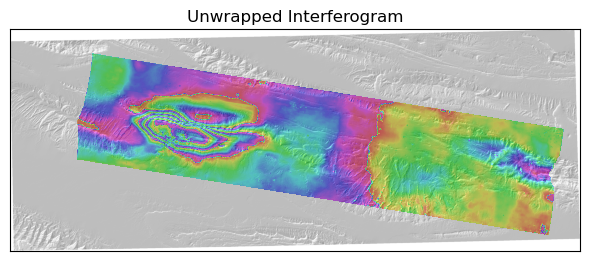

In [13]:
%matplotlib inline
import numpy as np
from pathlib import Path
from osgeo import gdal
import matplotlib
import matplotlib.pyplot as plt

product_name = 'S1_136231_IW2_20200604T022312_VV_7C85-BURSTxS1_136231_IW2_20200616T022313_VV_5D11-BURST'

unwrapped_file = Path(product_name) / f'{product_name}_wrapped_phase.tif'
dem_file = Path(product_name) / f'{product_name}_dem.tif'

ds = gdal.Open(str(unwrapped_file))
unwrapped = np.ma.masked_equal(ds.GetRasterBand(1).ReadAsArray(), 0)
del ds

dem_ds = gdal.Open(str(dem_file))
gdal.DEMProcessing('hillshade.tif', dem_ds, 'hillshade')
hillshade_ds = gdal.Open('hillshade.tif')
hillshade = hillshade_ds.GetRasterBand(1).ReadAsArray()
del dem_ds, hillshade_ds

f, ax = plt.subplots(1,1, figsize=(6,6))
ax.imshow(unwrapped, alpha=0.7, cmap='hsv')
ax.imshow(hillshade, alpha=0.4, cmap='Greys')
ax.set_title('Unwrapped Interferogram')

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.tight_layout()